<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers as optim
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from IPython.display import clear_output
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)
%matplotlib inline

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of training examples: {len(train_images)} with shape: {train_images.shape}")
print(f"Number of testing examples: {len(test_images)} with shape: {test_images.shape}")

Number of training examples: 60000 with shape: (60000, 28, 28)
Number of testing examples: 10000 with shape: (10000, 28, 28)


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) /127.5  

BUFFER_SIZE = 60000
BATCH_SIZE = 512

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Size of noise vector 
noise_dim = 128

In [0]:
img_shape = (28, 28, 1)

In [0]:
from tensorflow.keras.layers import *

In [0]:
# def conv_block(x,
#                 filters,
#                 activation, 
#                 kernel_size=(3,3),
#                 strides=(1,1),
#                 padding="same",
#                 use_bias=True,
#                 use_bn=False,
#                 use_dropout=False,
#                 drop_value=0.5):
    
#     x = layers.Conv2D(filters, 
#                       kernel_size, 
#                       strides=strides,
#                       padding=padding,
#                       use_bias=use_bias)(x)
#     if use_bn:
#         x = layers.BatchNormalization()(x)
#     x = activation(x)
#     if use_dropout:
#         x = layers.Dropout(drop_value)(x)
#     return x

In [0]:
def get_discriminator_model():
    disc = Sequential()
    inputShape = (28, 28, 1)

    disc.add(Conv2D(32, (5, 5), padding="same", strides=(2, 2),
        input_shape=inputShape))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Conv2D(64, (5, 5), padding="same", strides=(2, 2)))
    disc.add(LeakyReLU(alpha=0.2))

    disc.add(Flatten())
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dropout(0.3))
    disc.add(Dense(1))
    return disc

In [9]:
d_model = get_discriminator_model()
d_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0

In [0]:
# def upsample_block(x,
#                    filters,
#                    activation,
#                    kernel_size=(3,3),
#                    strides=(1,1),
#                    up_size=(2,2),
#                    padding="same",
#                    use_bn=False,
#                    use_bias=True,
#                    use_dropout=False,
#                    drop_value=0.3
#                    ):
    
#     x = layers.UpSampling2D(up_size)(x)
#     x = layers.Conv2D(filters, 
#                       kernel_size, 
#                       strides=strides,
#                       padding=padding,
#                       use_bias=use_bias)(x)
    
#     if use_bn:
#         x = layers.BatchNormalization()(x)
    
#     x = activation(x)
#     if use_dropout:
#         x = layers.Dropout(drop_value)(x)
#     return x    

In [0]:
def get_generator_model():
    generator = Sequential()
    inputShape = (7, 7, 64)
    chanDim = -1

    generator.add(Dense(input_dim=128, units=512, use_bias=False))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Dense(7 * 7 * 64, use_bias=False))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())

    generator.add(Reshape(inputShape))
    generator.add(Conv2DTranspose(32, (5, 5), strides=(2, 2),
        padding="same", use_bias=False))
    generator.add((LeakyReLU()))
    generator.add(BatchNormalization(axis=chanDim))

    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2),
        padding="same", activation="tanh"))
    return generator

In [12]:
g_model = get_generator_model()
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              1605632   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)         

In [0]:
# metrics to keep track of the mean loss for eah epoch
gen_metric = tf.keras.metrics.Mean()
disc_metric = tf.keras.metrics.Mean()

# Optimizer for both the networks
# lr=0.0002, beta_1=0.5 are recommened 
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

# Define the loss functions to be used for discrimiator 
# This should be -(real_loss - fake_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_labels = tf.ones_like(real_img)
    fake_labels = -tf.ones_like(fake_img)
    
    real_loss = -K.mean(real_labels*real_img)
    fake_loss = -K.mean(fake_labels*fake_img)
    
    return  real_loss + fake_loss

# Define the loss functions to be used for generator   
def generator_loss(fake_img):
    fake_lie_labels = tf.ones_like(fake_img)
    return -K.mean(fake_lie_labels*fake_img)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=g_model,
                                 discriminator=d_model)

EPOCHS = 500
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_g(num_samples):
    # 1. Generate random noise
    noise = tf.random.normal([num_samples,  noise_dim], dtype=tf.float32)

    # 2. Generate image and get the loss as well as gradients
    with tf.GradientTape() as tape:
        generated_images = g_model(noise, training=True)
        gen_img_logits = d_model(generated_images, training=True)
        gen_loss = generator_loss(gen_img_logits)
    
    gen_gradient = tape.gradient(gen_loss, g_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_gradient, 
                                             g_model.trainable_variables))
    return gen_loss

#-------------------------------------------------------------------------------

def gradient_penalty(real_images, fake_images):
    # Each image would get a random number in the batch 
    # This number would be of shape: (num_samples, 1, 1, 1)
    # Remember each image has h x w x nb_channels
    alpha = np.random.uniform(size=(len(real_images), 1, 1, 1))
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    
    # Perform interpolation
    interpolated = (alpha * real_images) + ((1 - alpha) * fake_images)
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = d_model(interpolated, training=True)

    # Compute the Gradient Penalty term
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    
    return gp

#-------------------------------------------------------------------------------

@tf.function
def train_d(real_images, gp_weight=10.0):
    noise = tf.random.normal((len(real_images),  noise_dim), dtype=tf.float32)
    with tf.GradientTape() as tape:
        fake_images = g_model(noise, training=True)
        fake_logits = d_model(fake_images, training=True)
        real_logits = d_model(real_images, training=True)

        disc_loss = discriminator_loss(real_img=real_logits,
                                       fake_img=fake_logits)
        
        gp = gradient_penalty(real_images, fake_images)
        cost = disc_loss + gp*gp_weight

    disc_gradient = tape.gradient(cost, d_model.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_gradient,
                                                d_model.trainable_variables))
    return cost

#-------------------------------------------------------------------------------

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(10,10))
  for i in range(predictions.shape[0]):
      pred = predictions[i, :, :, 0] * 127.5 + 127.5
      pred = pred.astype(np.uint8)
      plt.subplot(4, 4, i+1)
      plt.imshow(pred, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
# Number of batches
nb_batches = len(train_images) // BATCH_SIZE
nb_batches

117

In [0]:
for single_batch in train_dataset.take(1):
    single_batch = single_batch
    pass

preds = d_model(single_batch)

In [19]:
tf.reduce_mean(preds).numpy()

0.093803614

In [20]:
K.mean(tf.ones_like(preds) * preds).numpy()

0.093803614

Epcoh: 0  batch: 0 g_loss: -0.460, d_loss: 4.953


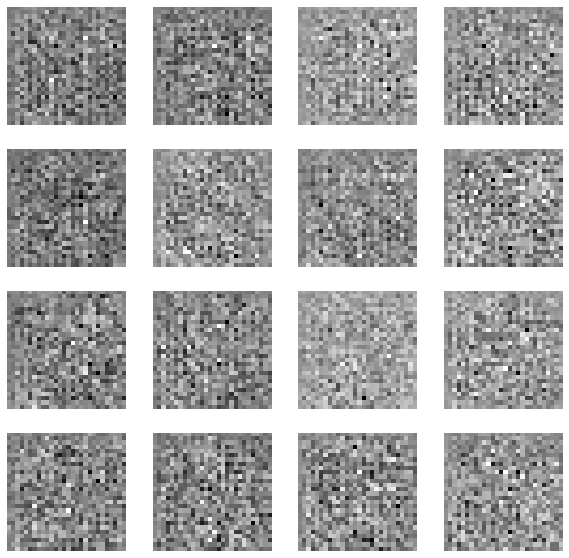

Epcoh: 1  batch: 0 g_loss: -9.597, d_loss: -4.778


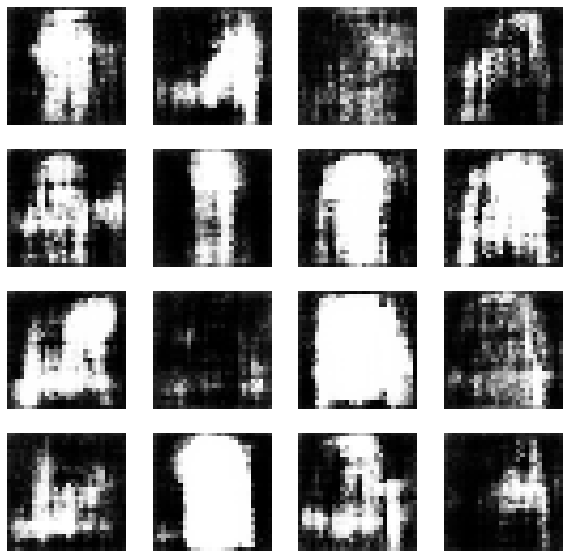

Epcoh: 2  batch: 0 g_loss: -12.576, d_loss: -3.854


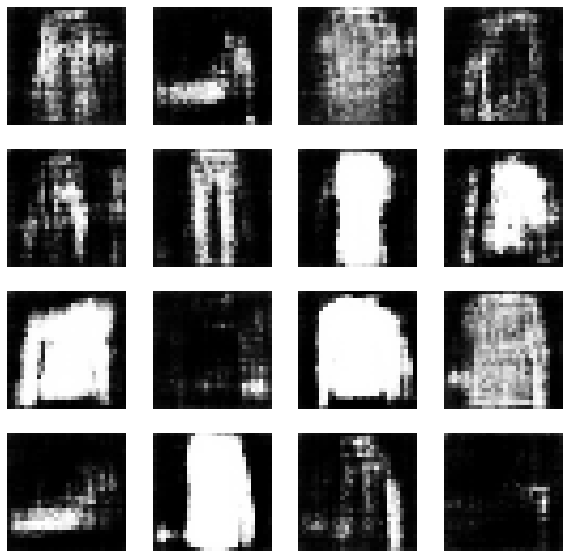

Epcoh: 3  batch: 0 g_loss: -9.971, d_loss: -3.314


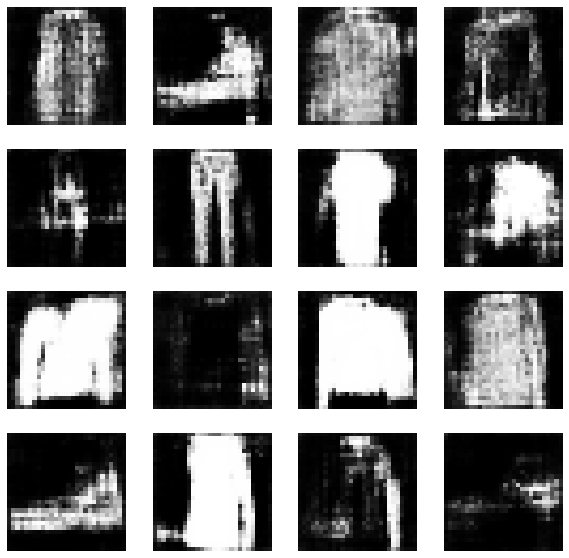

Epcoh: 4  batch: 0 g_loss: -3.273, d_loss: -3.218


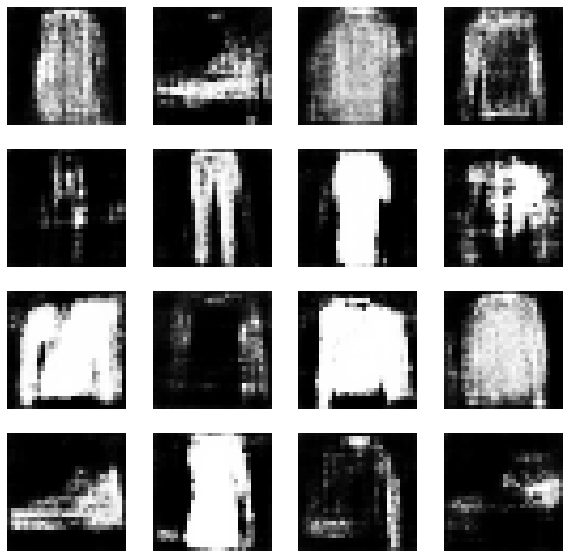

Epcoh: 5  batch: 0 g_loss: -2.303, d_loss: -2.574


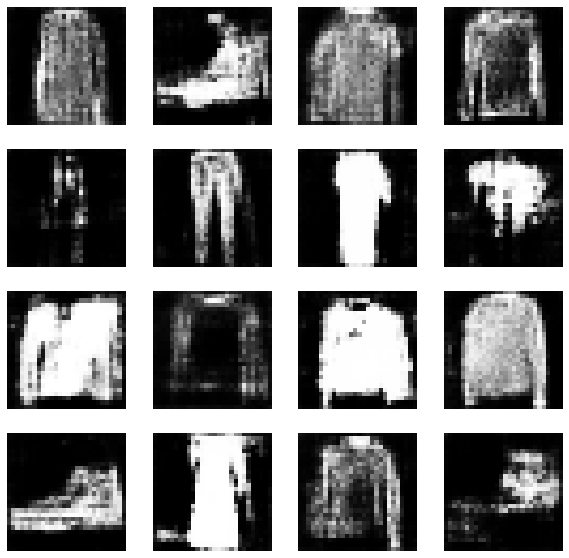

Epcoh: 6  batch: 0 g_loss: -0.830, d_loss: -2.362


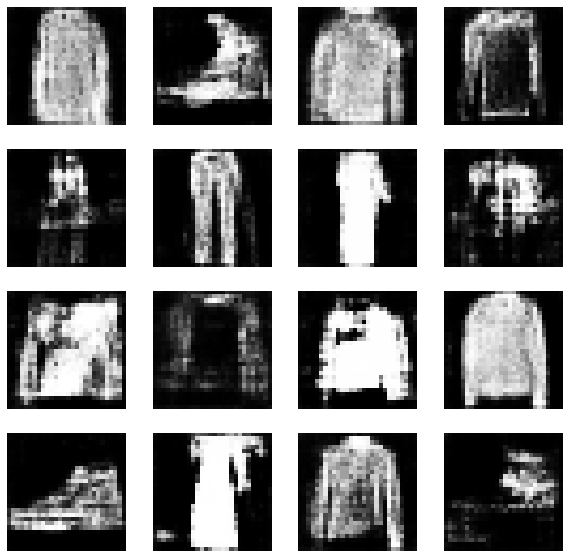

Epcoh: 7  batch: 0 g_loss: -0.317, d_loss: -2.181


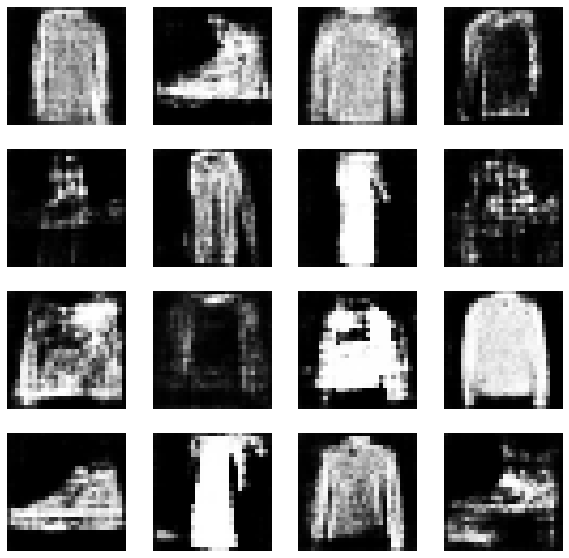

Epcoh: 8  batch: 0 g_loss: 1.359, d_loss: -2.328


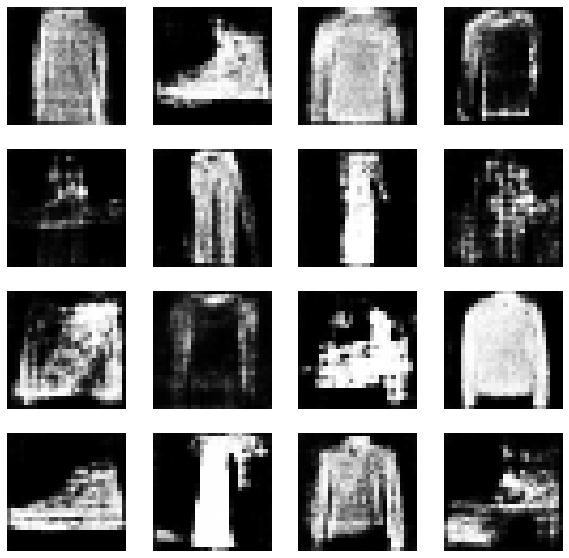

Epcoh: 9  batch: 0 g_loss: 0.345, d_loss: -1.990


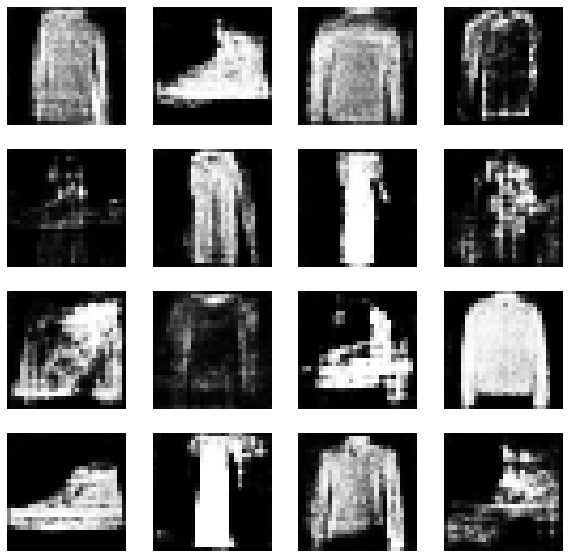

Epcoh: 10  batch: 0 g_loss: 2.266, d_loss: -1.954


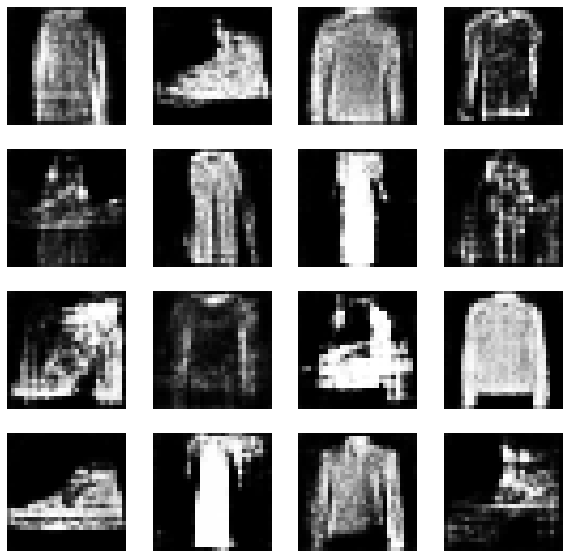

Epcoh: 11  batch: 0 g_loss: 3.659, d_loss: -2.063


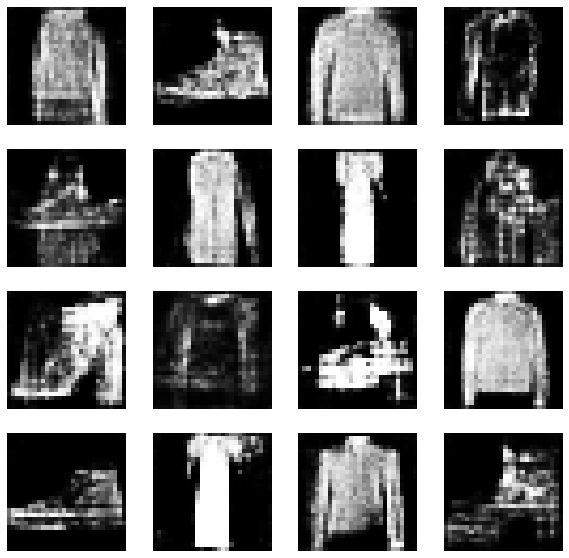

Epcoh: 12  batch: 0 g_loss: 2.851, d_loss: -1.757


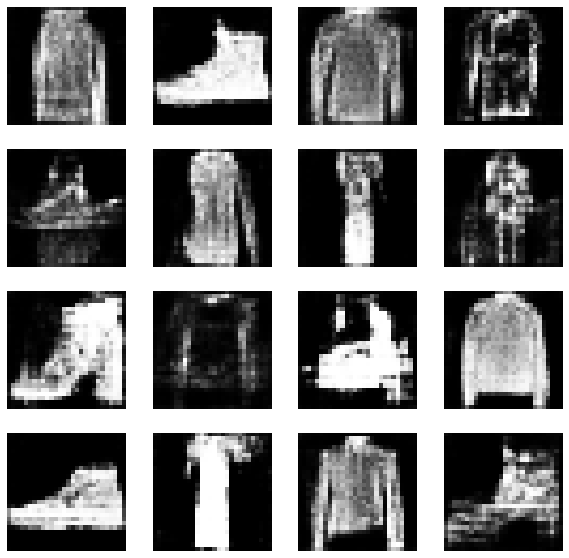

Epcoh: 13  batch: 0 g_loss: 2.005, d_loss: -1.718


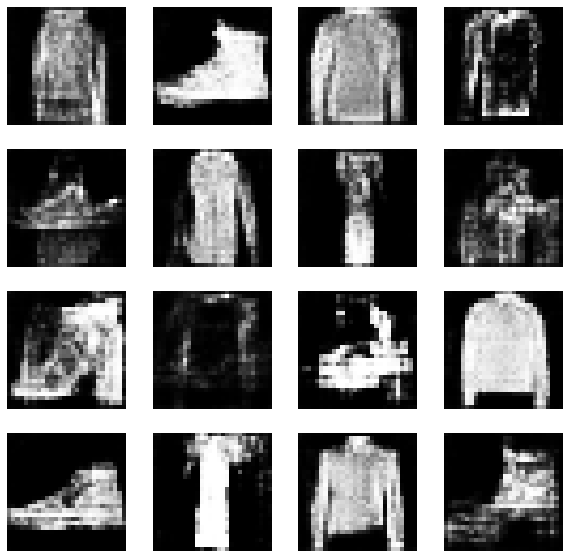

Epcoh: 14  batch: 0 g_loss: 3.371, d_loss: -1.868


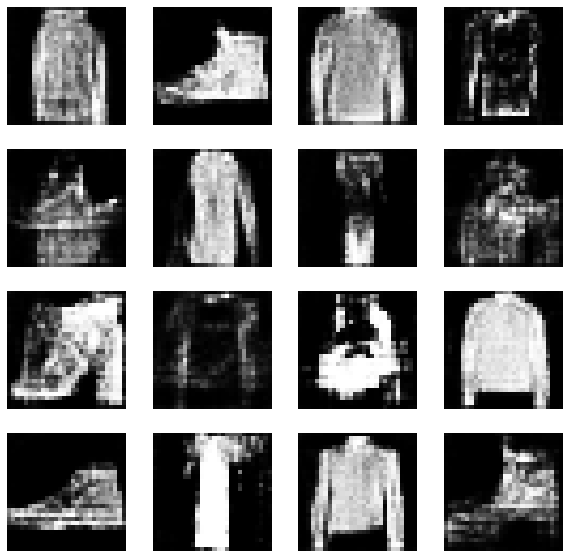

Epcoh: 15  batch: 0 g_loss: 5.205, d_loss: -1.867


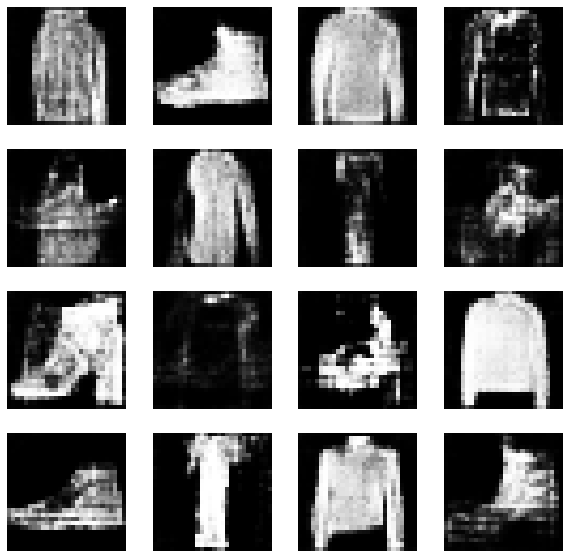

Epcoh: 16  batch: 0 g_loss: 4.692, d_loss: -1.638


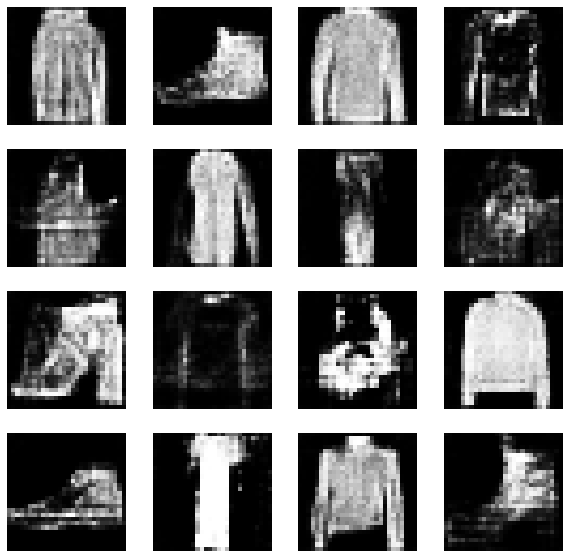

Epcoh: 17  batch: 0 g_loss: 3.785, d_loss: -1.947


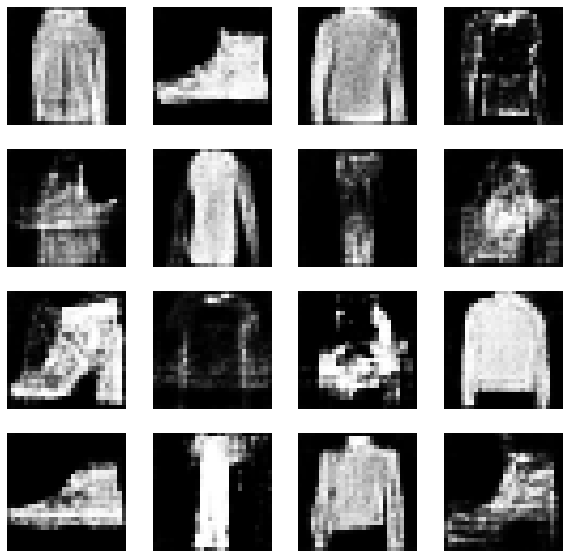

Epcoh: 18  batch: 0 g_loss: 5.076, d_loss: -1.576


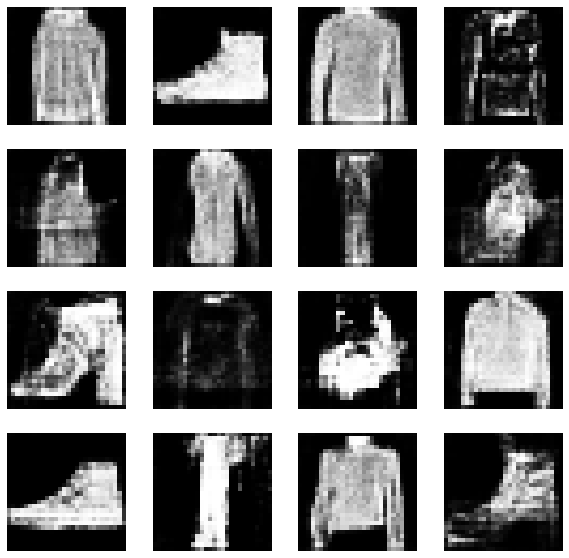

Epcoh: 19  batch: 0 g_loss: 4.507, d_loss: -1.846


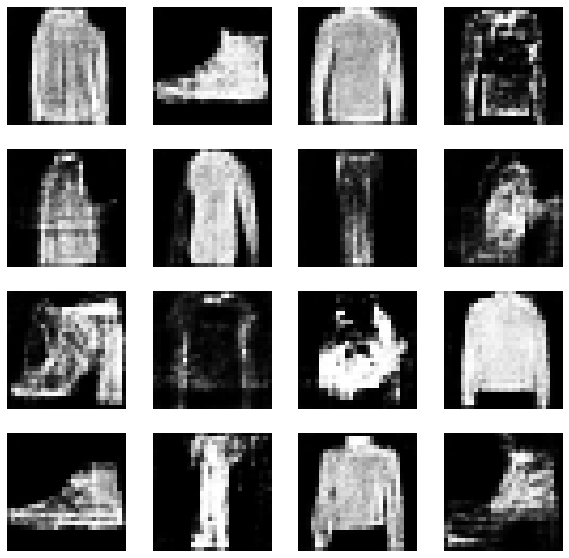

Epcoh: 20  batch: 0 g_loss: 2.845, d_loss: -1.561


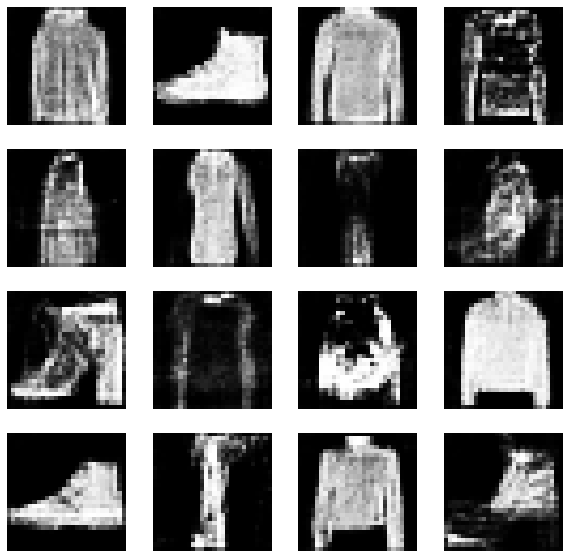

Epcoh: 21  batch: 0 g_loss: 1.912, d_loss: -1.797


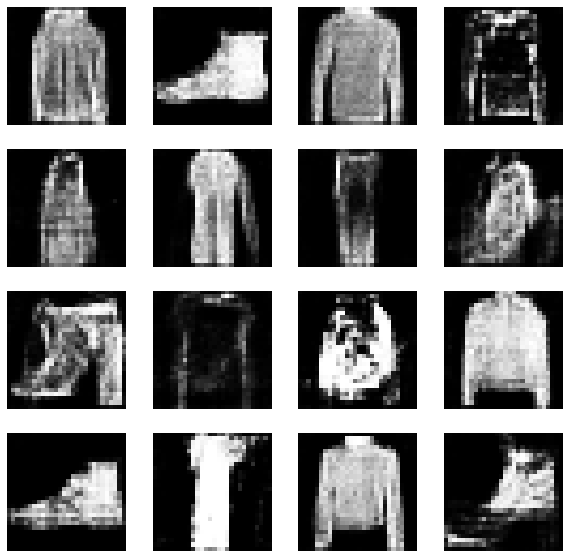

Epcoh: 22  batch: 0 g_loss: 5.900, d_loss: -1.585


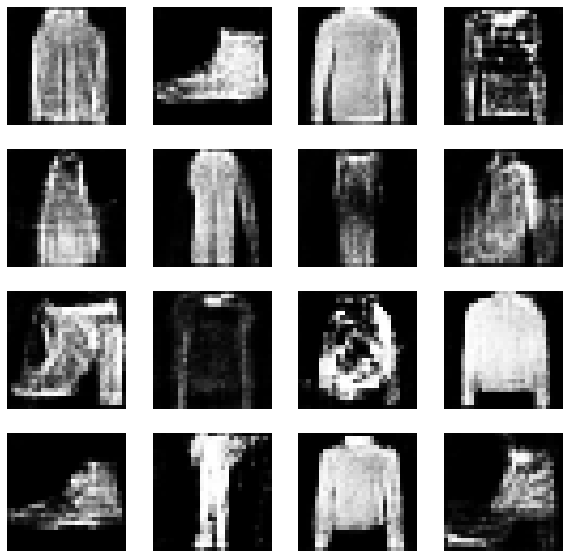

Epcoh: 23  batch: 0 g_loss: 5.446, d_loss: -1.424


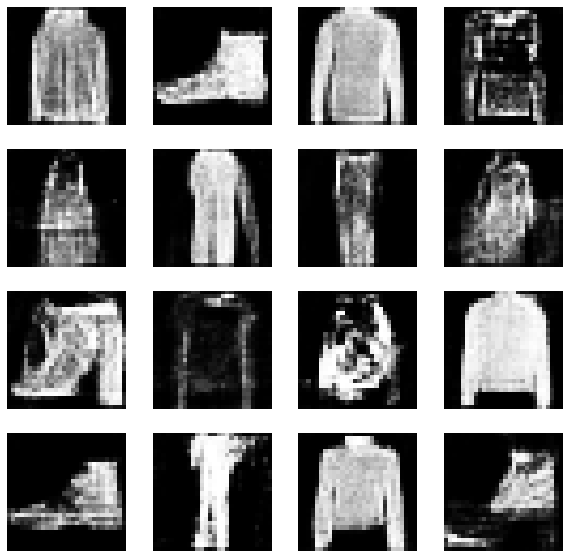

Epcoh: 24  batch: 0 g_loss: 5.249, d_loss: -1.314


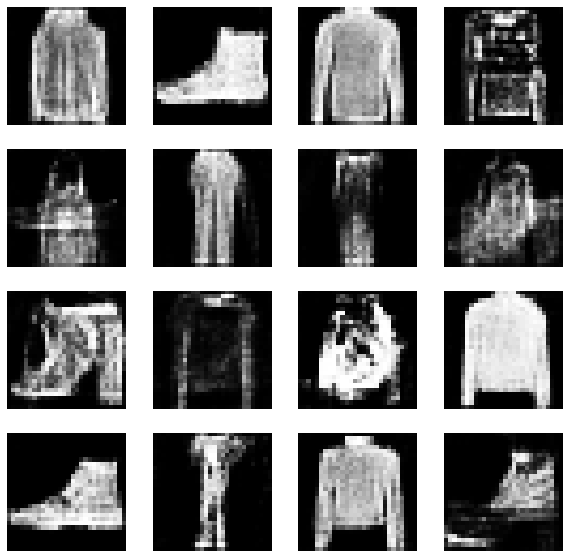

Epcoh: 25  batch: 0 g_loss: 5.116, d_loss: -1.608


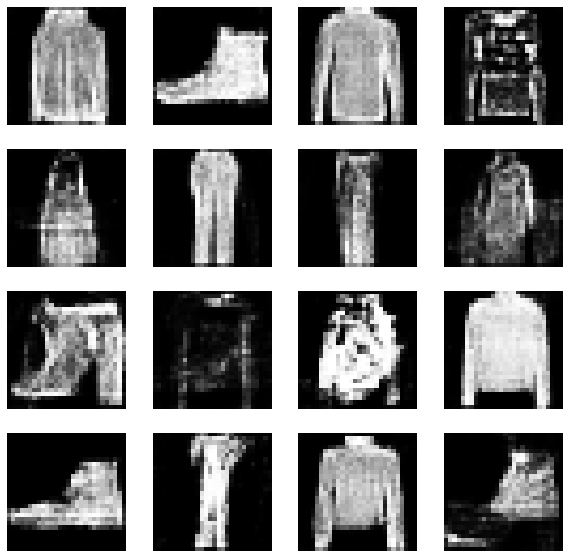

Epcoh: 26  batch: 0 g_loss: 5.832, d_loss: -1.054


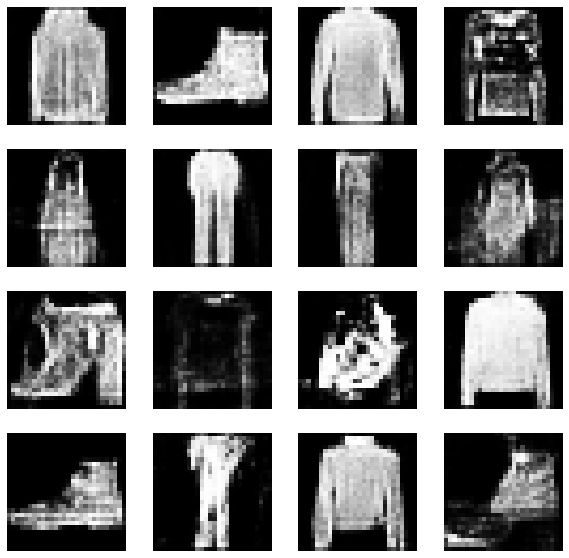

Epcoh: 27  batch: 0 g_loss: 5.307, d_loss: -1.132


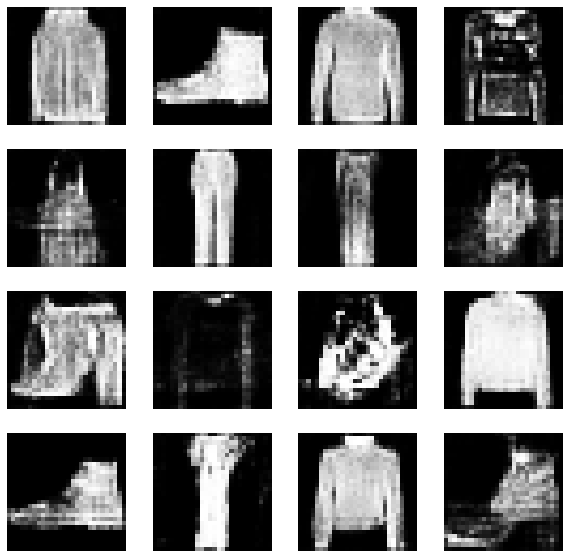

Epcoh: 28  batch: 0 g_loss: 2.527, d_loss: -0.897


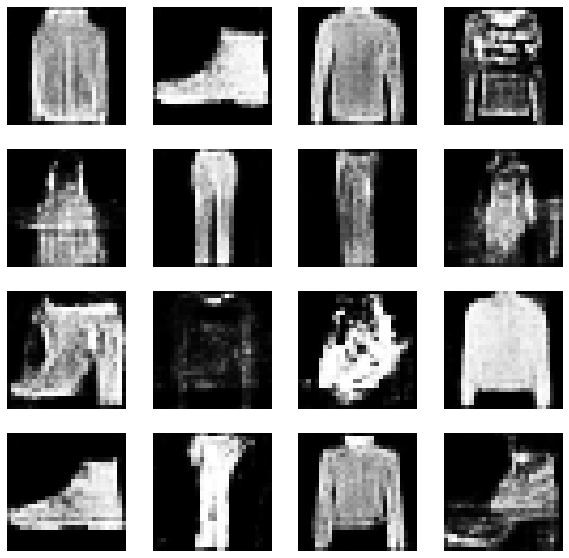

Epcoh: 29  batch: 0 g_loss: 7.443, d_loss: -1.592


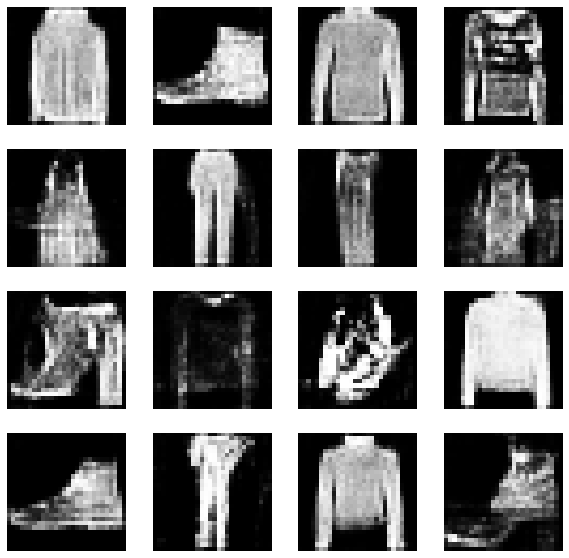

Epcoh: 30  batch: 0 g_loss: 6.926, d_loss: -1.191


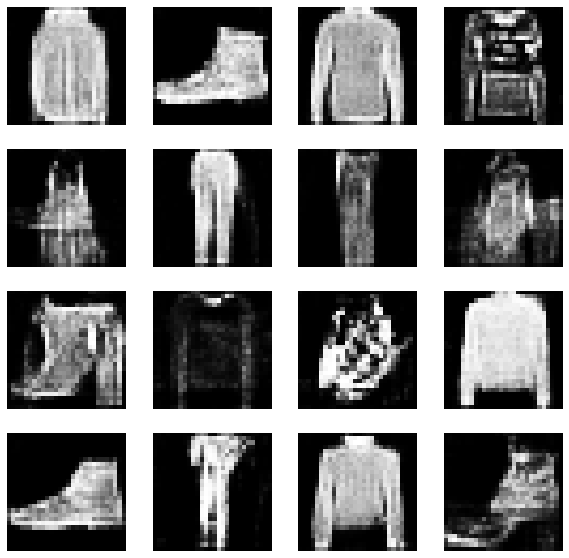

Epcoh: 31  batch: 0 g_loss: 7.473, d_loss: -0.742


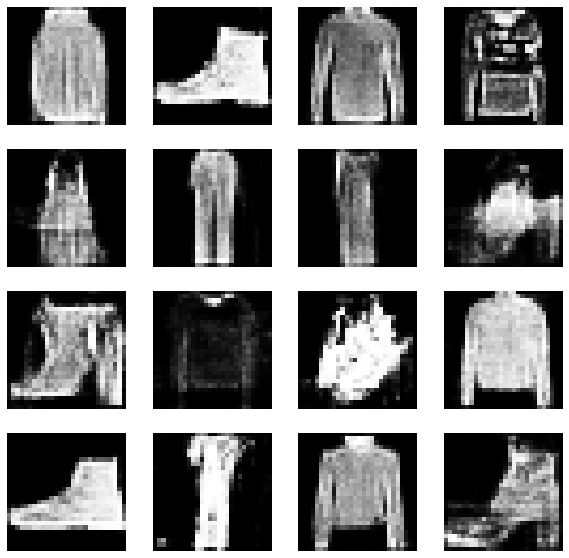

Epcoh: 32  batch: 0 g_loss: 6.977, d_loss: -1.205


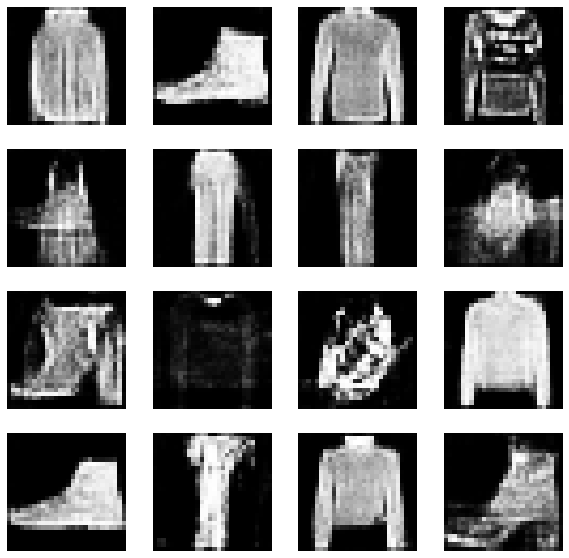

Epcoh: 33  batch: 0 g_loss: 5.420, d_loss: -1.243


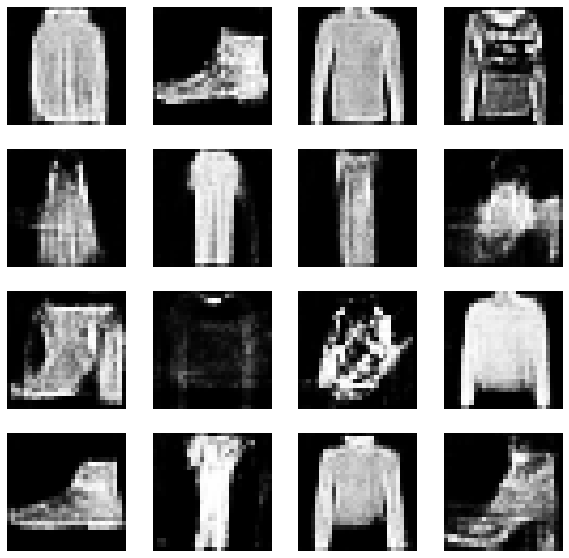

In [0]:
 for epoch in range(EPOCHS):
    for bno, batch in enumerate(train_dataset):
        for _ in range(3):
            train_d(batch)
            d_loss = train_d(batch)
            disc_metric(d_loss)

        g_loss = train_g(len(batch))
        train_g(len(batch))
        gen_metric(g_loss)

        if bno%200==0:            
            print(f"Epcoh: {epoch}  batch: {bno} g_loss: {gen_metric.result():.3f}, d_loss: {disc_metric.result():.3f}")
            generate_and_save_images(g_model, bno + 1, noise_seed)
            # clear_output(wait=True)
            
    checkpoint.save(file_prefix = checkpoint_prefix)
    gen_metric.reset_states()
    disc_metric.reset_states()